Import all appropriate Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression



Lets first import the data.

In [2]:
#Load datasets

df_red = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Red.csv")
df_Rose = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Rose.csv")
df_sparkling = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Sparkling.csv")
df_white = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/White.csv")

df = pd.concat([df_red, df_Rose, df_sparkling, df_white], ignore_index=True)

# Reclassify quality into categories
def categorize_quality(q):
    if q <= 3:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_category"] = df["Rating"].round().apply(categorize_quality)
    
    

We now need to preprocess the data, specifically we need a way to quantify the location of the wine.

In [8]:

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df 



red_onehot = pd.get_dummies(df, columns=['Country', 'Region', 'Winery'])
# Remove rows where Price > 200

red_onehot.drop(['Name'], axis=1, inplace=True)
red_onehot.dropna(inplace=True)



--- Linear Regression Results ---
Linear Regression RMSE: 11.28


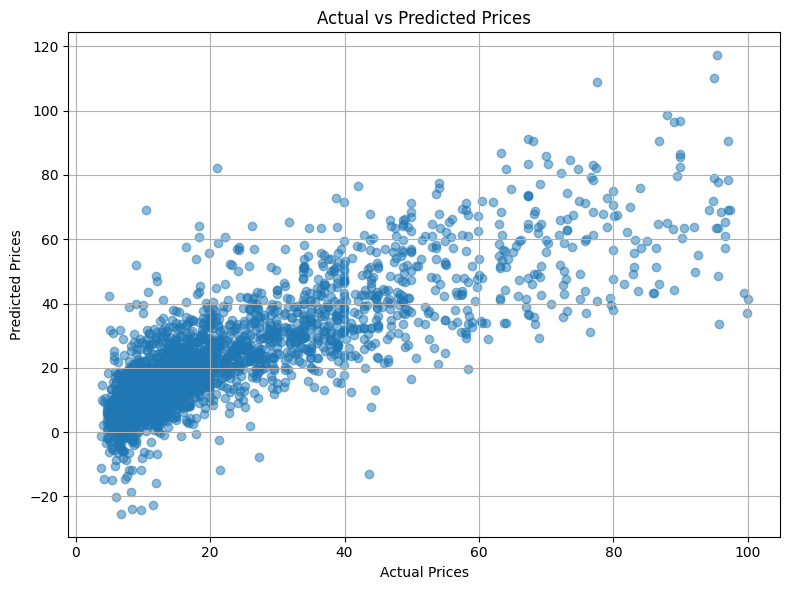

In [9]:
# Prepare data for regression
X = red_onehot.drop(["Price", "quality_category"], axis=1)
y = red_onehot["Price"]

# Convert 'Year' to numeric, coerce errors, and fill NaN with median year
if 'Year' in X.columns:
	X['Year'] = pd.to_numeric(X['Year'], errors='coerce')
	median_year = X['Year'].median()
	X['Year'] = X['Year'].fillna(median_year)

# Train-test split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Predict on test set
y_pred_lr = lr_model.predict(X_test_lr)

# Evaluate model
mse = mean_squared_error(y_test_lr, y_pred_lr)
rmse = np.sqrt(mse)

print("--- Linear Regression Results ---")

print(f"Linear Regression RMSE: {rmse:.2f}")


# plot actual vs predicted

plt.figure(figsize=(8, 6))
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.scatter(y_test_lr, y_pred_lr, alpha=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

--- Gradient Boosting Results ---
Mean Squared Error: 4826.02
Root Mean Squared Error: 69.47
Mean Absolute Error: 13.84
R² Score: 0.42


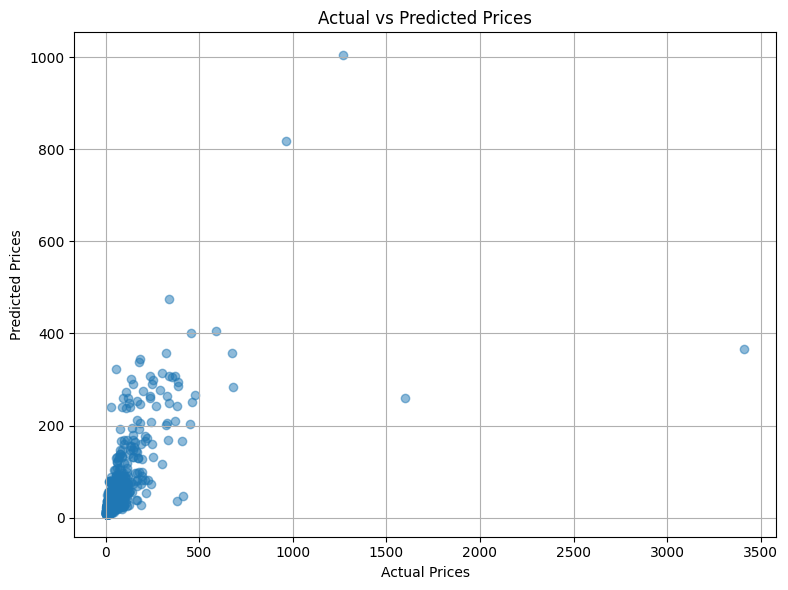

In [18]:
# --- Load and preprocess data ---
# Replace 'NV' with NaN
red_onehot.replace("NV", np.nan, inplace=True)

# Convert 'Year' to numeric and fill missing values with median
if 'Year' in red_onehot.columns:
    red_onehot['Year'] = pd.to_numeric(red_onehot['Year'], errors='coerce')
    median_year = red_onehot['Year'].median()
    red_onehot['Year'] = red_onehot['Year'].fillna(median_year)

# One-hot encode categorical variables (if any)
red_onehot = pd.get_dummies(red_onehot, drop_first=True)

# Drop remaining rows with missing values
red_onehot = red_onehot.dropna()

# --- Prepare features and target ---
X = red_onehot.drop(["Price", "quality_category_high", "quality_category_medium"], axis=1, errors='ignore')
y = red_onehot["Price"]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train Gradient Boosting Regressor ---
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# --- Predictions and Evaluation ---
y_pred = gb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- Gradient Boosting Results ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# --- Plot Actual vs Predicted Prices ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

Ridge Lasso

--- Ridge Regression Results ---
Mean Squared Error: 7048.13
Root Mean Squared Error: 83.95
Mean Absolute Error: 22.59
R² Score: 0.15



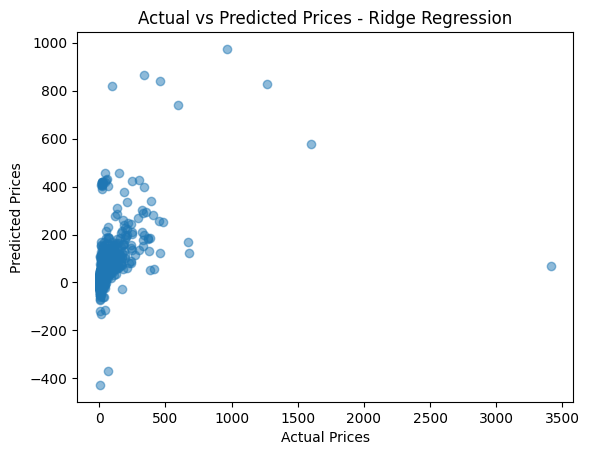

--- Lasso Regression Results ---
Mean Squared Error: 5770.44
Root Mean Squared Error: 75.96
Mean Absolute Error: 16.58
R² Score: 0.31



Text(0.5, 1.0, 'Actual vs Predicted Prices - Lasso Regression')

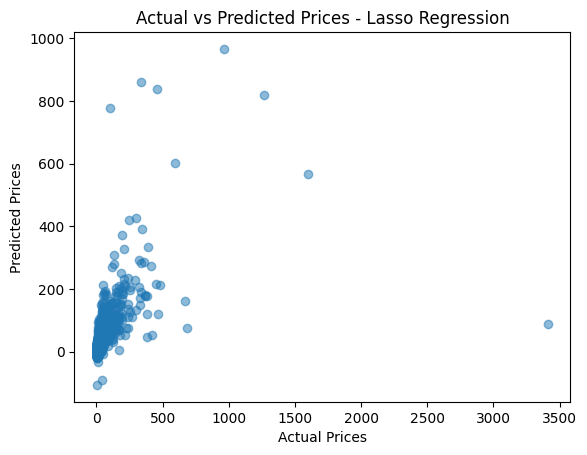

In [19]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare features and target
X = red_onehot.drop(["Price", "quality_category_high", "quality_category_medium"], axis=1, errors='ignore')
y = red_onehot["Price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"--- {name} Regression Results ---")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {mse**0.5:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.2f}\n")

evaluate_model("Ridge", y_test, y_pred_ridge)

plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices - Ridge Regression")
plt.show()
evaluate_model("Lasso", y_test, y_pred_lasso)
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices - Lasso Regression")
